<a href="https://colab.research.google.com/github/19marquee/rabbit-challenge/blob/main/machine-learning/logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# レポート 機械学習/ロジスティック回帰モデル


## 100文字以内の要点のまとめ

ロジスティック回帰
- 分類モデルを解くための手法。分類モデルは、ある入力からクラスに分類する問題。（二値分類、多値分類など）
- ロジスティック線形回帰モデルは、入力とパラメータの線形結合をシグモイド関数に入力して出力を得る。出力は0から1の範囲の値となり、y=1になる確率を表す。  
シグモイド関数は、$\sigma(x) = \dfrac{1}{1+\exp(-ax)}$  
aを増加させると、曲線の勾配が増加し、単位ステップ関数に近似する。
- シグモイド関数の微分は、シグモイド関数自身で表せる。
シグモイド関数の微分は、$\dfrac{\partial \sigma(x)}{\partial x} = a\sigma(x)(1-\sigma(x))$
- 出力の確率が0.5以上なら1、未満なら0と分類

最尤推定

- データを集めたとき、そのデータはどんな分布から生成されたのかを問うことが、最尤推定のモチベーション。
- 尤度関数とは、データは固定、パラメータが未知（可変）の、確率の分布を表す関数。尤度関数を最大化するような分布（パラメータ）を推定する方法を最尤推定という。
- ロジスティック回帰モデルの最尤推定では、確率$p$がシグモイド関数によって求められるため、推定するパラメータは、重みパラメータ$w$
- 実際に学習する際は、負の対数尤度を用いる。
- 勾配降下法でパラメータの学習を行う。回帰問題とは異なり、解析的に解を求めるのは難しい。全てのデータに対する和を求める必要がある。
- 確率的勾配降下法とは、確率的にデータを一つずつ選んでパラメータを更新する。勾配降下法と確率的勾配降下法のバランスをとった手法として、ミニバッチ勾配降下法がある。

評価手法、視標

- ロジスティック回帰モデルの性能を測る代表的な指標として、再現率、適合率、F値がある。
- 再現率は、本当にpositiveなものの中で、正しくpsitiveと予測できている割合。一方、適合率は、モデルがAだと予測したものの中で、正しくAと予測できている割合。
- 再現率と適合率はトレードオフで、F値は両者の調和平均。


##実習演習結果

#### Googleドライブのマウント

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### データ表示

In [79]:
#from モジュール名 import クラス名（もしくは関数名や変数名）
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#matplotlibをinlineで表示するためのおまじない (plt.show()しなくていい)
%matplotlib inline

以下では，Googleドライブのマイドライブ直下にstudy_ai_ml_googleフォルダを使用します。

In [80]:
# titanic data csvファイルの読み込み
titanic_df = pd.read_csv('/content/drive/My Drive/study_ai_ml_google/data/titanic_train.csv')

In [81]:
# ファイルの先頭部を表示し、データセットを確認する
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### 1. ロジスティック回帰
不要なデータの削除・欠損値の補完

In [82]:
#予測に不要と考えるからうをドロップ (本当はここの情報もしっかり使うべきだと思っています)
titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

#一部カラムをドロップしたデータを表示
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [83]:
#nullを含んでいる行を表示
titanic_df[titanic_df.isnull().any(1)].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,male,NaN,0,0,8.4583,Q
17,1,2,male,NaN,0,0,13.0000,S
19,1,3,female,NaN,0,0,7.2250,C
26,0,3,male,NaN,0,0,7.2250,C
28,1,3,female,NaN,0,0,7.8792,Q
29,0,3,male,NaN,0,0,7.8958,S
31,1,1,female,NaN,1,0,146.5208,C
32,1,3,female,NaN,0,0,7.7500,Q
36,1,3,male,NaN,0,0,7.2292,C
42,0,3,male,NaN,0,0,7.8958,C


In [84]:
#Ageカラムのnullを中央値で補完

titanic_df['AgeFill'] = titanic_df['Age'].fillna(titanic_df['Age'].mean())

#再度nullを含んでいる行を表示 (Ageのnullは補完されている)
titanic_df[titanic_df.isnull().any(1)]

#titanic_df.dtypes

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill
5,0,3,male,NaN,0,0,8.4583,Q,29.699118
17,1,2,male,NaN,0,0,13.0000,S,29.699118
19,1,3,female,NaN,0,0,7.2250,C,29.699118
26,0,3,male,NaN,0,0,7.2250,C,29.699118
28,1,3,female,NaN,0,0,7.8792,Q,29.699118
...,...,...,...,...,...,...,...,...,...
859,0,3,male,NaN,0,0,7.2292,C,29.699118
863,0,3,female,NaN,8,2,69.5500,S,29.699118
868,0,3,male,NaN,0,0,9.5000,S,29.699118
878,0,3,male,NaN,0,0,7.8958,S,29.699118


#### 1. ロジスティック回帰
実装(チケット価格から生死を判別)

In [85]:
#運賃だけのリストを作成
data1 = titanic_df.loc[:, ["Fare"]].values

In [86]:
#生死フラグのみのリストを作成
label1 =  titanic_df.loc[:,["Survived"]].values

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
model=LogisticRegression()

In [89]:
model.fit(data1, label1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
model.predict([[61]])

array([0])

In [91]:
model.predict([[62]])

array([1])

In [92]:
model.predict_proba([[61]])

array([[0.50358033, 0.49641967]])

In [93]:
model.predict_proba([[62]])

array([[0.49978123, 0.50021877]])

入力（Fare）が62を超えると、出力（Survived）が1に変化。61と62の確率を確認すると、ほぼ0.5

In [94]:
X_test_value = model.decision_function(data1) 

In [95]:
# # 決定関数値（絶対値が大きいほど識別境界から離れている）
# X_test_value = model.decision_function(X_test) 
# # 決定関数値をシグモイド関数で確率に変換
# X_test_prob = normal_sigmoid(X_test_value) 

In [96]:
print (model.intercept_)

print (model.coef_)

[-0.94131796]
[[0.01519666]]


No handles with labels found to put in legend.


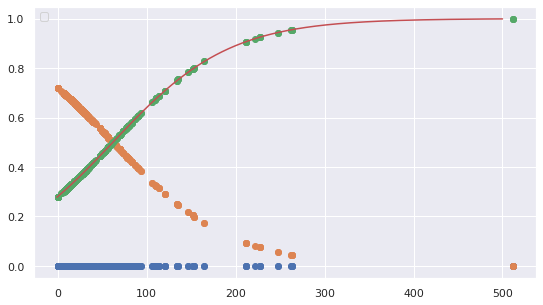

In [97]:
w_0 = model.intercept_[0]
w_1 = model.coef_[0,0]

# def normal_sigmoid(x):
#     return 1 / (1+np.exp(-x))

def sigmoid(x):
    return 1 / (1+np.exp(-(w_1*x+w_0)))

x_range = np.linspace(-1, 500, 3000)

plt.figure(figsize=(9,5))
#plt.xkcd()
plt.legend(loc=2)


# plt.ylim(-0.1, 1.1)
# plt.xlim(-10, 10)

# plt.plot([-10,10],[0,0], "k", lw=1)
# plt.plot([0,0],[-1,1.5], "k", lw=1)
plt.plot(data1,np.zeros(len(data1)), 'o')
plt.plot(data1, model.predict_proba(data1), 'o')
plt.plot(x_range, sigmoid(x_range), '-')
#plt.plot(x_range, normal_sigmoid(x_range), '-')
#




入力（Fare）を変化させた時の確率の推移を確認。

#### 1. ロジスティック回帰
実装(2変数から生死を判別)

In [98]:
#AgeFillの欠損値を埋めたので
#titanic_df = titanic_df.drop(['Age'], axis=1)

In [99]:
titanic_df['Gender'] = titanic_df['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [100]:
titanic_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1
1,1,1,female,38.0,1,0,71.2833,C,38.0,0
2,1,3,female,26.0,0,0,7.9250,S,26.0,0


In [101]:
titanic_df['Pclass_Gender'] = titanic_df['Pclass'] + titanic_df['Gender']

In [102]:
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeFill,Gender,Pclass_Gender
0,0,3,male,22.0,1,0,7.2500,S,22.0,1,4
1,1,1,female,38.0,1,0,71.2833,C,38.0,0,1
2,1,3,female,26.0,0,0,7.9250,S,26.0,0,3
3,1,1,female,35.0,1,0,53.1000,S,35.0,0,1
4,0,3,male,35.0,0,0,8.0500,S,35.0,1,4


In [103]:
titanic_df = titanic_df.drop(['Pclass', 'Sex', 'Gender','Age'], axis=1)

In [104]:
titanic_df.head()

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3
3,1,1,0,53.1000,S,35.0,1
4,0,0,0,8.0500,S,35.0,4


In [105]:
# 重要だよ！！！
# 境界線の式
#   w_1・x + w_2・y + w_0 = 0
#   ⇒ y = (-w_1・x - w_0) / w_2
 
# # 境界線 プロット
# plt.plot([-2,2], map(lambda x: (-w_1 * x - w_0)/w_2, [-2,2]))
 
# # データを重ねる
# plt.scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='red', marker='x', label='train 0')
# plt.scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='blue', marker='x', label='train 1')
# plt.scatter(X_test_std[y_test==0, 0], X_test_std[y_test==0, 1], c='red', marker='o', s=60, label='test 0')
# plt.scatter(X_test_std[y_test==1, 0], X_test_std[y_test==1, 1], c='blue', marker='o', s=60, label='test 1')

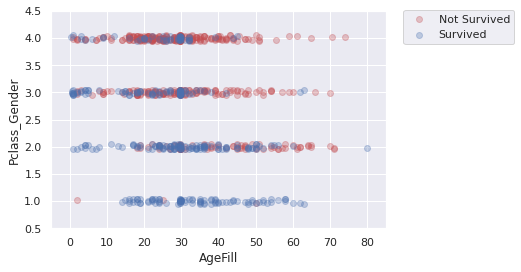

In [106]:
np.random.seed = 0

xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5

index_survived = titanic_df[titanic_df["Survived"]==0].index
index_notsurvived = titanic_df[titanic_df["Survived"]==1].index

from matplotlib.colors import ListedColormap
fig, ax = plt.subplots()
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)
ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.legend(bbox_to_anchor=(1.4, 1.03))

グラフより、Pclass_Genderが1で、AgeFillが10台と、Pclass_Genderが2、AgeFillが0～15歳は高確率でSurvivedすると推測できる。

In [107]:
#運賃だけのリストを作成
data2 = titanic_df.loc[:, ["AgeFill", "Pclass_Gender"]].values

In [108]:
data2

array([[22.        ,  4.        ],
       [38.        ,  1.        ],
       [26.        ,  3.        ],
       ...,
       [29.69911765,  3.        ],
       [26.        ,  2.        ],
       [32.        ,  4.        ]])

In [109]:
#生死フラグのみのリストを作成
label2 =  titanic_df.loc[:,["Survived"]].values

In [110]:
model2 = LogisticRegression()

In [111]:
model2.fit(data2, label2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [112]:
model2.predict([[10,1]])

array([1])

In [113]:
model2.predict_proba([[10,1]])

array([[0.03754749, 0.96245251]])

In [114]:
titanic_df.head(3)

,Survived,SibSp,Parch,Fare,Embarked,AgeFill,Pclass_Gender
0,0,1,0,7.2500,S,22.0,4
1,1,1,0,71.2833,C,38.0,1
2,1,0,0,7.9250,S,26.0,3


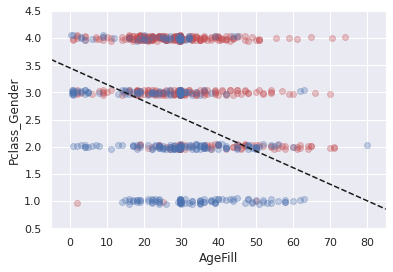

In [115]:
h = 0.02
xmin, xmax = -5, 85
ymin, ymax = 0.5, 4.5
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
Z = model2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
levels = np.linspace(0, 1.0)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#contour = ax.contourf(xx, yy, Z, cmap=cm, levels=levels, alpha=0.5)

sc = ax.scatter(titanic_df.loc[index_survived, 'AgeFill'],
                titanic_df.loc[index_survived, 'Pclass_Gender']+(np.random.rand(len(index_survived))-0.5)*0.1,
                color='r', label='Not Survived', alpha=0.3)
sc = ax.scatter(titanic_df.loc[index_notsurvived, 'AgeFill'],
                titanic_df.loc[index_notsurvived, 'Pclass_Gender']+(np.random.rand(len(index_notsurvived))-0.5)*0.1,
                color='b', label='Survived', alpha=0.3)

ax.set_xlabel('AgeFill')
ax.set_ylabel('Pclass_Gender')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
#fig.colorbar(contour)

x1 = xmin
x2 = xmax
y1 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmin)/model2.coef_[0][1]
y2 = -1*(model2.intercept_[0]+model2.coef_[0][0]*xmax)/model2.coef_[0][1]
ax.plot([x1, x2] ,[y1, y2], 'k--')

決定境界による、Survive,Not Surviveの分離ができていることを確認。

#### 2. モデル評価
混同行列とクロスバリデーション

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
traindata1, testdata1, trainlabel1, testlabel1 = train_test_split(data1, label1, test_size=0.2)
traindata1.shape
trainlabel1.shape

(712, 1)

In [118]:
traindata2, testdata2, trainlabel2, testlabel2 = train_test_split(data2, label2, test_size=0.2)
traindata2.shape
trainlabel2.shape
#本来は同じデータセットを分割しなければいけない。(簡易的に別々に分割している。)

(712, 1)

In [119]:
data = titanic_df.loc[:, ].values
label =  titanic_df.loc[:,["Survived"]].values
traindata, testdata, trainlabel, testlabel = train_test_split(data, label, test_size=0.2)
traindata.shape
trainlabel.shape

(712, 1)

In [120]:
eval_model1=LogisticRegression()
eval_model2=LogisticRegression()
#eval_model=LogisticRegression()

In [121]:
predictor_eval1=eval_model1.fit(traindata1, trainlabel1).predict(testdata1)
predictor_eval2=eval_model2.fit(traindata2, trainlabel2).predict(testdata2)
#predictor_eval=eval_model.fit(traindata, trainlabel).predict(testdata)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [122]:
eval_model1.score(traindata1, trainlabel1)

0.6643258426966292

In [123]:
eval_model1.score(testdata1,testlabel1)

0.659217877094972

In [124]:
eval_model2.score(traindata2, trainlabel2)

0.7696629213483146

In [125]:
eval_model2.score(testdata2,testlabel2)

0.7821229050279329

In [126]:
from sklearn import metrics
print(metrics.classification_report(testlabel1, predictor_eval1))
print(metrics.classification_report(testlabel2, predictor_eval2))

              precision    recall  f1-score   support

           0       0.65      0.94      0.77       108
           1       0.71      0.24      0.36        71

    accuracy                           0.66       179
   macro avg       0.68      0.59      0.56       179
weighted avg       0.67      0.66      0.61       179

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       113
           1       0.73      0.65      0.69        66

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



混合行列を出力する。

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix1=confusion_matrix(testlabel1, predictor_eval1)
confusion_matrix2=confusion_matrix(testlabel2, predictor_eval2)

In [128]:
confusion_matrix1

array([[101,   7],
       [ 54,  17]])

In [129]:
confusion_matrix2

array([[97, 16],
       [23, 43]])

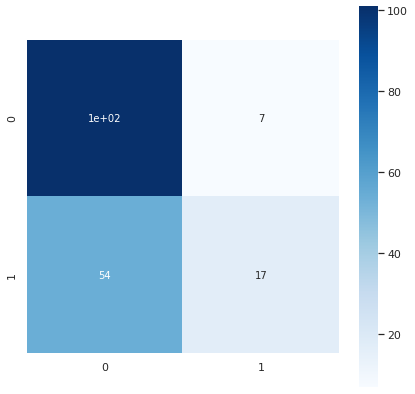

In [130]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix1,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

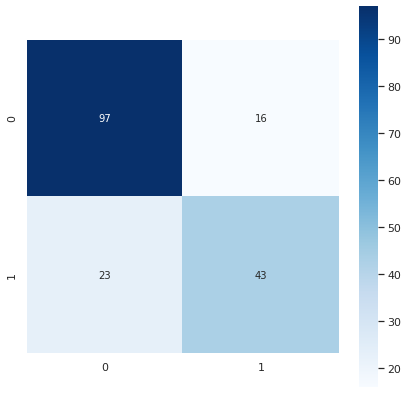

In [131]:
fig = plt.figure(figsize = (7,7))
#plt.title(title)
sns.heatmap(
    confusion_matrix2,
    vmin=None,
    vmax=None,
    cmap="Blues",
    center=None,
    robust=False,
    annot=True, fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=True, ax=None, 
    #xticklabels=columns,
    #yticklabels=columns,
    mask=None)

class、sex、who、aloneの各要素（特徴）ごとのsurvived(生還する確率)の分布を可視化する。

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


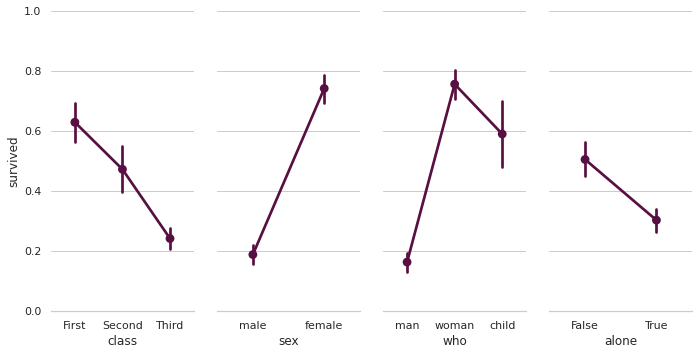

In [132]:
#Paired categorical plots

import seaborn as sns
sns.set(style="whitegrid")

# Load the example Titanic dataset
titanic = sns.load_dataset("titanic")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(titanic, y_vars="survived",
                 x_vars=["class", "sex", "who", "alone"],
                 size=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, color=sns.xkcd_rgb["plum"])
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

plt.show()

男性は子供より生き残る確率が低く、女性は高い、など単体の要素（特徴）における考察や推測が可能になる。

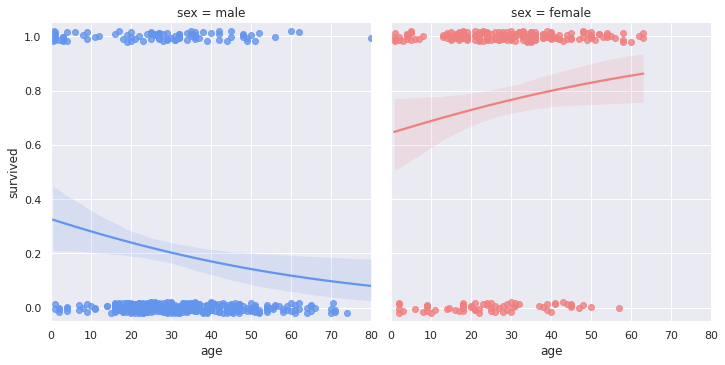

In [133]:
#Faceted logistic regression

import seaborn as sns
sns.set(style="darkgrid")

# Load the example titanic dataset
df = sns.load_dataset("titanic")

# Make a custom palette with gendered colors
pal = dict(male="#6495ED", female="#F08080")

# Show the survival proability as a function of age and sex
g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=.02, logistic=True)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))
plt.show()

グラフより、基本的に女性の方が男性よりも生き残る（Survivedの）確率が高いといえる。